In [1]:
from qiskit.tools.jupyter import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [2]:
# get backend information
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse" # check for OpenPulse support

In [3]:
# can find sampling times for backend pulses within backend configuration
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") # dt is returned in seconds, convert to nanoseconds
## Warnings can be safely ignored

Sampling time: 0.2222222222222222 ns


/opt/conda/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:355: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [4]:
# backend defaults give starting point for how to use backend, contains estimates for qubit
# frequencies and default programs to enact basic quantum operators
backend_defaults = backend.defaults()

# Part 1
1 Finding the qubit frequency using frequency sweep

* qubit frequency is difference in E b/w |0>, |1>
* need frequency for pulses to perform quantum operations on qubits
* superconducting qubits - higher energies also available, but anharmonic so we can control which transition we are exciting -> Allows us to isolate two energy levels and treat each qubit as basic two-level system (distance between energy levels *non-linear*, scrunches up as you go to |2>, |3> but very wide for |0>, |1>
* typically sweep through range of frequencies and look for signs of absorption 
  * define a frequency range that will be swept, then a "step amount" (ex: +/- 40 Mhz w/ 1Mhz stepping


In [7]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following (only) qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
## take the central frequency, then subtrac by half the span to est. min-max bounds
frequency_min = center_frequency_Hz - frequency_span_Hz / 2 
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
## np.arange, return evenly spaced values within given interval. If step is non-integer, consider
## using np.linspace
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
# Safe to ignore warnings

Qubit 0 has an estimated frequency of 4.974290529121356 GHz.
The sweep will go from 4.954290529121356 GHz to 4.994290529121356 GHz in steps of 1.0 MHz.


* start by defining *drive pulse*, a kind of Gaussian pulse
* all pulse durations are given in `dt` units.

In [8]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [9]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

* When acquisition is done for one qubit, it is also done on other qubits
* acquisition seems to mean triggering the ADC associated with a qubit, triggers data collection for channel associated with a qubit 

In [11]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map): #meas_map = list of sets of qubits that must be measured together
    if qubit in measure_group: # pick one qubit from the measure group
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [12]:
# define measurement pulse
# Instead of hardcoding, obtain a calibrated measurement pulse from backend default instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [13]:
# Specify channels on which we apply pulses
# channels indexed by qubit number 
## According to arxiv paper, each qubit has two channels
## * drive channel + measurement input (stimulus) channel
## * signal on drive channel for qubit i is mixed with user-specificed local oscillator at
##   certain frequency -> interacts with qubit through hamiltonian
## * measurement channel also gets "mixed" with local oscillator
## https://arxiv.org/pdf/1809.03452.pdf
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [16]:
## w/ pulse params + pulse shapes, can create pulse schedule
## at each frequency, send drive pulse of frequency to qubit and perform measurement
## immediately after pulse.

## pulse envelopes independent of frequency so can build reusable schedule
## specify drive pulse frequency with a frequency configuration array

# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

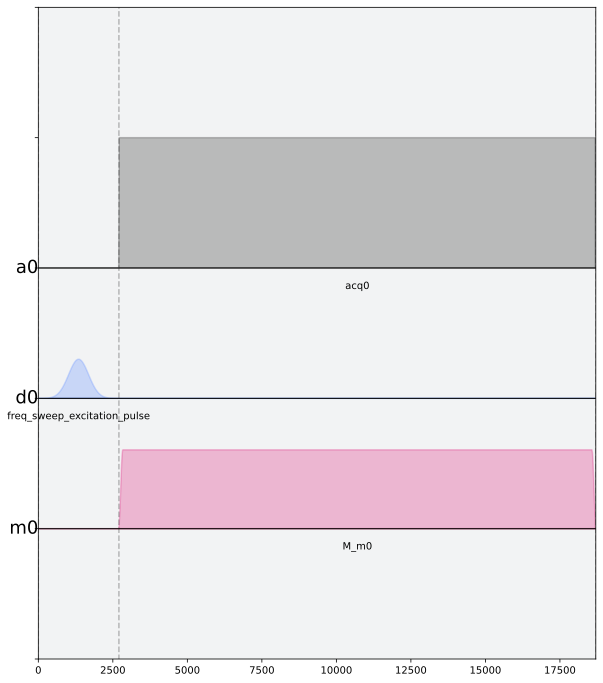

In [17]:
schedule.draw(channels=[drive_chan, meas_chan, acq_chan], label=True, scaling=1.0)

In [18]:
from qiskit import assemble

num_shots_per_frequency = 1024
# assemble into a Qobj sent to quantum device
## meas_level = 0 raw data (array of cmplx vals per shot)
## meas_level = 1 kerneled data (kerneled data, 1 cmplex val per shot)
## meas_level = 2 returns classified (0/1 per shot)
## choose meas_level = 1 to replicate lab conditions, where discriminator hasn't been calibrated
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg', # ask for average of results
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


In [19]:
job = backend.run(frequency_sweep_program)

In [20]:
print(job.job_id())

5eb106826d2c84001180a97e


In [21]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [22]:
frequency_sweep_results = job.result(timeout=120)

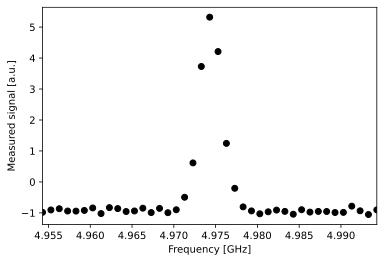

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

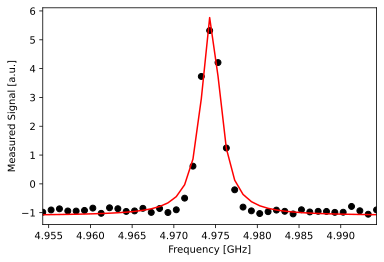

In [25]:
# to get value of peak frequency, fit values to resonance response curve, typically a lorentzian shape
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [26]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97429 GHz to 4.97441 GHz.
